# Import libs

In [1]:
# Import some stuff
import os
from dotenv import load_dotenv
from pathlib import Path
from pymongo import MongoClient
import matplotlib.pyplot as plt
import pandas as pd
import ast
import datetime
import seaborn as sns
import json
import numpy as np

import matplotlib as mpl
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

from datetime import datetime
from dateutil.parser import parse
import pandas as pd


from pandas.io.json import json_normalize
from PIL import Image


#need to translate from wgs to bng to do spatial clustering
import pyproj

In [2]:
import folium

In [3]:
#plotly info
plotly.tools.set_credentials_file(username='aclong', api_key='A9dlryDYONXram1rzbki')

In [4]:
# specifies number of rows to show
pd.set_option('display.max_rows', 300) 

# specifies default number format to 4 decimal places
pd.options.display.float_format = '{:40,.4f}'.format 

# specifies that graphs should use ggplot styling
plt.style.use('ggplot') 

%matplotlib inline

In [8]:
# load .env variable
base_dir = 'D:\Documentos\GitHub\CityBlender'
dotenv_file = os.path.join(base_dir, '.env')

# base_dir = 'C:/Users/Alfie/Documents/MSc Smart Cities/Term 2/Spatial Data Capture Storage and Analysis/Coursework/Analysis Test/'
# dotenv_file = os.path.join(base_dir, '.env')


if os.path.isfile(dotenv_file):
    load_dotenv(dotenv_file, verbose=True)
    
db_uri = os.getenv('DB_URI')

In [9]:
# create a new MongoDB Client
db_client = MongoClient(str(db_uri))

# If it's ok it should return a 1.0
db_client.london.command("serverStatus")['ok']

1.0

In [10]:
# choose a database to connect to (.london)
db_london = db_client.london

# choose a collection
db_london_events = db_london['events']
db_london_artist = db_london['artists']

In [11]:
# lookup all the documents in a collection
db_london_events.find()

## EOD

In [12]:
events = pd.DataFrame(list(db_london_events.find({})))

In [13]:
events.columns

Index(['_id', 'artists', 'date', 'datetime', 'datetime_source', 'foursquare',
       'id', 'lastfm', 'location', 'name', 'popularity', 'spotify', 'time',
       'type', 'url', 'venue'],
      dtype='object')

### For instance in the first row there are 3 events

In [14]:
# Put this in the date fomrat
events['date'] = [(datetime.strptime(events['date'][x], '%Y-%m-%d')) for x in range(len(events['date']))]

# Convert the dates into day name
events['date_name'] = [(events['date'][x].strftime("%A")) for x in range(len(events['date']))]

# Lat & Long
events['lat'] = [(events['location'][x]['lat']) for x in range(len(events['location']))]
events['lng'] = [(events['location'][x]['lng']) for x in range(len(events['location']))]

# Plotly Stuff

In [15]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly

## City Level

In [16]:
import fiona
from mpl_toolkits.basemap import Basemap   
import pandas as pd
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon
from shapely.prepared import prep
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from descartes import PolygonPatch

# DB SCAN

In [17]:
#clustering
from sklearn.cluster import DBSCAN
from scipy import cluster
from sklearn import metrics

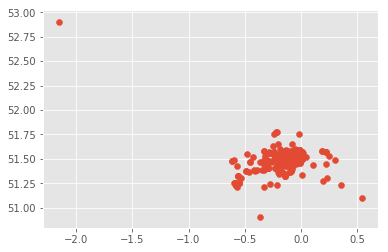

In [18]:
plt.scatter(events['lng'], events['lat'])

In [19]:
subset = events[events['lat']<52]

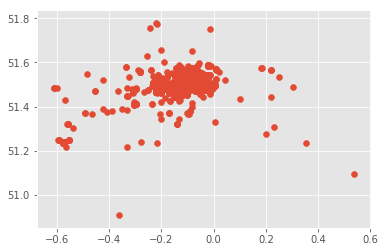

In [20]:
plt.scatter(subset['lng'], subset['lat'])

In [21]:
subset = subset[subset['lat']>51.2]

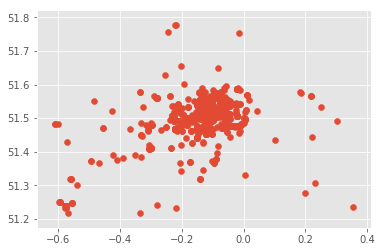

In [22]:
plt.scatter(subset['lng'], subset['lat'])

In [23]:
def SCANING_DB(eps_var = 600 , min_sample_var = 5, db = subset, lat_var = 'lat', lng_var = 'lng'):
    dbscan = DBSCAN(eps=eps_var, min_samples = min_sample_var)
#     print(dbscan) 
    arrey_coords = db[[lat_var, lng_var]].values
    #print(arrey_coords)
    #try clustering out on the whole dataset
    dbscan_result = dbscan.fit(arrey_coords)
    dbscan_result_lbls = dbscan_result.labels_
    return(dbscan_result_lbls)
    
    

# Convert to BNG

In [24]:
#need to translate from wgs to bng to do spatial clustering
import pyproj

In [25]:
#to do clustering locations need to be in BNG so that distances are in metres
#Define projections using EPSG codes
wgs84=pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by songkick
osgb36=pyproj.Proj("+init=EPSG:27700") # UK Ordnance Survey, 1936 datum, for locations in eastings/northings/metres

#create a new pd without NaNs
londonEventsdfNoNan = subset[subset['lat'].notnull()]

#make new columns for the new latlng
londonEventsdfNoNan['BNGnorthing'] = ""
londonEventsdfNoNan['BNGeasting'] = ""

#reset the index - londonEventsdfNoNan now main dataframe
londonEventsdfNoNan = londonEventsdfNoNan.reset_index()

In [26]:
#run through the dataset and transform those coordinates
origLat = []
origLng = []

for i in range(0,len(londonEventsdfNoNan)):
    # print(i)
    try:
        origLat.append(londonEventsdfNoNan['lat'][i])
        origLng.append(londonEventsdfNoNan['lng'][i])
        
    except:
        origLat.append(np.nan)
        origLng.append(np.nan)

In [27]:
lat,lon = pyproj.transform(wgs84,osgb36,origLng,origLat)
    
londonEventsdfNoNan['BNGeasting'] = lat
londonEventsdfNoNan['BNGnorthing'] = lon

In [28]:
#now convert from object to numeric
londonEventsdfNoNan['BNGnorthing'] = pd.to_numeric(londonEventsdfNoNan['BNGnorthing'])
londonEventsdfNoNan['BNGeasting'] = pd.to_numeric(londonEventsdfNoNan['BNGeasting'])

In [29]:
londonEventsdfNoNan

,index,_id,artists,date,datetime,datetime_source,foursquare,id,lastfm,location,...,spotify,time,type,url,venue,date_name,lat,lng,BNGnorthing,BNGeasting
0,0,5af9c6dc0cc9ab0004e227d1,[{'mbid': ['aca5718f-4f49-4439-b8f6-209db3f117...,2018-05-14,2018-05-14 18:00:00,2018-05-14T19:00:00+0100,"{'id': '4ac518e9f964a520daab20e3', 'name': 'Ro...",31245569,"{'listeners': [412072, 57, 192843], 'listeners...","{'lng': -0.1491962, 'lat': 51.5429551}",...,"{'genres': [], 'popularity': [64, 25, 32], 'po...",19:00:00,Concert,http://www.songkick.com/concerts/31245569-fran...,"{'id': 17874, 'name': 'Roundhouse', 'location'...",Monday,51.5430,-0.1492,"184,296.1993","528,443.9440"
1,1,5af9c6de0cc9ab0004e227d3,"[{'mbid': [], 'id': 8437833, 'name': 'Andy May...",2018-05-14,NaT,None,"{'id': '4ac518c5f964a520afa420e3', 'name': 'Th...",31640764,"{'listeners': [18], 'listeners_sum': 18, 'play...","{'lng': -0.1011681, 'lat': 51.5233496}",...,"{'genres': [], 'popularity': [3], 'popularity_...",None,Concert,http://www.songkick.com/concerts/31640764-andy...,"{'id': 6950, 'name': 'The Slaughtered Lamb', '...",Monday,51.5233,-0.1012,"182,201.3522","531,830.8516"
2,2,5af9c6e30cc9ab0004e227d6,[{'mbid': ['6655955b-1c1e-4bcb-84e4-81bcd9efab...,2018-05-14,2018-05-14 17:45:00,2018-05-14T18:45:00+0100,"{'id': '4ac518e8f964a52075ab20e3', 'name': 'Ro...",31785344,"{'listeners': [721424, 19477], 'listeners_sum'...","{'lng': -0.1781517, 'lat': 51.500786}",...,"{'genres': ['bow pop', 'chamber pop', 'composi...",18:45:00,Concert,http://www.songkick.com/concerts/31785344-olaf...,"{'id': 17538, 'name': 'Royal Albert Hall', 'lo...",Monday,51.5008,-0.1782,"179,556.4100","526,552.8784"
3,3,5af9c6e50cc9ab0004e227d8,[{'mbid': ['d100e4ac-31f1-4af1-b0e1-f07c545abb...,2018-05-14,2018-05-14 18:00:00,2018-05-14T19:00:00+0100,"{'id': '53713174498e54bcdede7275', 'name': 'Up...",32044684,"{'listeners': [313], 'listeners_sum': 313, 'pl...","{'lng': -0.1038429, 'lat': 51.5466983}",...,"{'genres': ['scottish folk'], 'popularity': [3...",19:00:00,Concert,http://www.songkick.com/concerts/32044684-elep...,"{'id': 434301, 'name': 'Thousand Island (forme...",Monday,51.5467,-0.1038,"184,792.9986","531,578.0036"
4,4,5af9c6eb0cc9ab0004e227db,[{'mbid': ['366323f3-0409-4a30-a3e9-ce1e25d277...,2018-05-14,2018-05-14 18:30:00,2018-05-14T19:30:00+0100,"{'id': '4b5e0cfdf964a520037b29e3', 'name': 'Bu...",32192284,"{'listeners': [7057, 3625], 'listeners_sum': 1...","{'lng': -0.2314873, 'lat': 51.5062847}",...,"{'genres': [], 'popularity': [25, 1], 'popular...",19:30:00,Concert,http://www.songkick.com/concerts/32192284-gary...,"{'id': 17541, 'name': 'Bush Hall', 'location':...",Monday,51.5063,-0.2315,"180,077.1048","522,836.2963"
5,5,5af9c6ed0cc9ab0004e227dd,[{'mbid': ['a1ef6bc8-2644-4b6d-aa21-27b630acf7...,2018-05-14,2018-05-14 18:30:00,2018-05-14T19:30:00+0100,{},32454499,"{'listeners': [113695], 'listeners_sum': 11369...","{'lng': -0.5541293, 'lat': 51.2486437}",...,"{'genres': ['pub rock', 'roots rock'], 'popula...",19:30:00,Concert,http://www.songkick.com/concerts/32454499-nils...,"{'id': 1262471, 'name': 'G Live', 'location': ...",Monday,51.2486,-0.5541,"150,934.1232","501,010.1269"
6,6,5af9c6ef0cc9ab0004e227df,[{'mbid': ['c1982570-8efb-4cf7-bb5b-c9c026c0e8...,2018-05-14,2018-05-14 18:00:00,2018-05-14T19:00:00+0100,"{'id': '59bbad4dfebf314eba5d9fbb', 'name': 'Br...",32492684,"{'listeners': [120157], 'listeners_sum': 12015...","{'lng': -0.0774607, 'lat': 51.5033289}",...,"{'genres': ['afropop', 'world'], 'popularity':...",19:00:00,Concert,http://www.songkick.com/concerts/32492684-lady...,"{'id': 3565864, 'name': 'Bridge Theatre', 'loc...",Monday,51.5033,-0.0775,"180,017.9391","533,533.9375"
7,7,5af9c6f00cc9ab0004e227e1,"[{'mbid': [], 'id': 6651674, 'name': 'Gemma Kh...",2018-05-14,2018-05-14 18:00:00,2018-05-14T19:00:00+0100,"{'id': '53aa2db3498e191dfd67bd05', 'name': 'Fo...",32649974,"{'listeners': [32], 'listeners_sum': 32, 'play...","{'lng': -0.1355174, 'lat': 51.5403054}",...,NaN,19:00:00,Concert,h

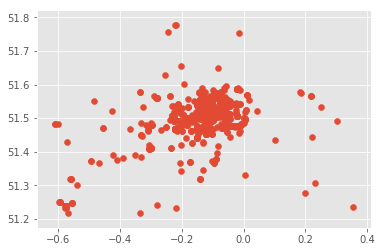

In [30]:
plt.scatter(londonEventsdfNoNan['lng'], londonEventsdfNoNan['lat'])

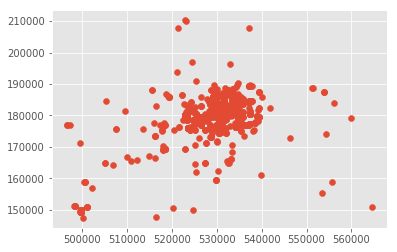

In [31]:
plt.scatter(londonEventsdfNoNan['BNGeasting'], londonEventsdfNoNan['BNGnorthing'])

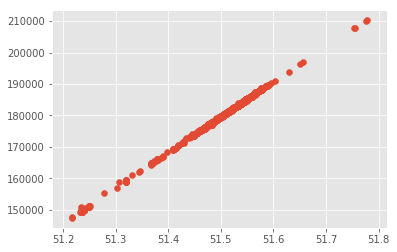

In [32]:
plt.scatter(londonEventsdfNoNan['lat'], londonEventsdfNoNan['BNGnorthing'])

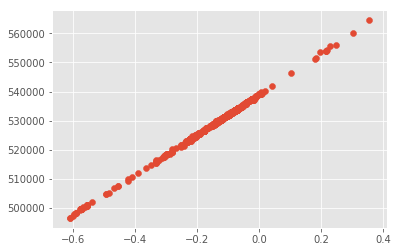

In [33]:
plt.scatter(londonEventsdfNoNan['lng'], londonEventsdfNoNan['BNGeasting'])

31
cluster
 0     1306
-1      192
 12      48
 10      39
 14      28
 4       26
 7       23
 1       23
 2       23
 15      17
 21      15
 22      14
 16      14
 18      13
 5       13
 6       12
 29      11
 20      11
 28      10
 11       9
 8        8
 25       7
 26       6
 13       6
 9        5
 23       5
 3        5
 17       5
 19       5
 27       5
 24       5
Name: _id, dtype: int64


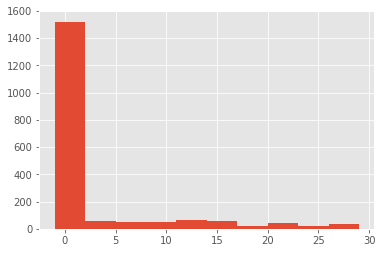

In [34]:
fitted = SCANING_DB(eps_var = 750, lat_var = 'BNGnorthing', lng_var = 'BNGeasting', db = londonEventsdfNoNan)
londonEventsdfNoNan['cluster'] = fitted
print(len(londonEventsdfNoNan['cluster'].unique()))
print(londonEventsdfNoNan.groupby('cluster').count()['_id'].sort_values(ascending = False))
londonEventsdfNoNan['cluster'].hist()

In [35]:
# Make a function to subset the genre depending on which dataset
def subset_by_genre(db, lib = 'spotify', words = 'reggae'):
    return db[db[lib].astype(str).str.contains(words, case=False)]

#create a genre compiling function
def genre_df_compiler(genreName, db = londonEventsdfNoNan):
    firstEventsdf = subset_by_genre(db, lib='spotify',words = genreName)
    secondEventsdf = subset_by_genre(db, lib='lastfm',words = genreName)
    allEventsdf = "all"+genreName+"Events" 
    allEventsdf = pd.concat([firstEventsdf, secondEventsdf])
    allEventsdf = allEventsdf.drop_duplicates(subset='_id', keep='last')
    return(allEventsdf)

# Test jazz

In [36]:
def eps_df_genre(db, epsMin = 1, epsMax = 2000, epsStep = 10, labelColName = "ClusterNosjazz", silColName = 'silhouScorejazz', lat_var = 'BNGnorthing', lng_var = 'BNGeasting'):
    clusterNos = []
    silhouScore = []
    epsValues = list(range(epsMin, epsMax, epsStep))
    epsDF = pd.DataFrame(epsValues)
    for i in epsValues:
        fitted = SCANING_DB(eps_var = i, lat_var = 'BNGnorthing', lng_var = 'BNGeasting', db = db)
        db['cluster'] = fitted
        array_coords = db[[lat_var, lng_var]].values
        silHouMet = metrics.silhouette_score(array_coords, fitted)
        silhouScore.append(silHouMet)
        clusterNos.append(len(db['cluster'].unique()))
    epsDF[labelColName] = pd.DataFrame(clusterNos)
    epsDF[silColName] = pd.DataFrame(silhouScore)
    return epsDF

In [37]:
# def get_silhouette_score(db = folk, lat_var = 'BNGnorthing', lng_var = 'BNGeasting', labelColName = 'folk500by5Labels'):
#     array_coords = db[[lat_var, lng_var]].values
#     labelsList = db[labelColName].tolist()
#     silHouMet = metrics.silhouette_score(array_coords, labelsList)
#     return(silHouMet)
# silHouMet = get_silhouette_score(db = jazz, lat_var = 'BNGnorthing', lng_var = 'BNGeasting', labelColName = 'cluster')

In [38]:

epsDFevents = eps_df_genre(db = londonEventsdfNoNan, labelColName = "ClusterNosevents", silColName = 'silhouScoreevents')

In [39]:
jazz =  genre_df_compiler('jazz', db = londonEventsdfNoNan)
jazz.reset_index(inplace = True)

In [40]:
epsDFjazz = eps_df_genre(db = jazz, labelColName = "ClusterNosjazz", silColName = 'silhouScorejazz')

In [41]:
punk =  genre_df_compiler('punk', db = londonEventsdfNoNan)
punk.reset_index(inplace = True)

In [42]:
epsDFpunk = eps_df_genre(db = punk, labelColName = "ClusterNospunk", silColName = 'silhouScorepunk')

In [43]:
techno =  genre_df_compiler('techno', db = londonEventsdfNoNan)
techno.reset_index(inplace = True)

In [44]:
epsDFtechno = eps_df_genre(db = techno, labelColName = "ClusterNostechno", silColName = 'silhouScoretechno')

In [45]:
folk =  genre_df_compiler('folk', db = londonEventsdfNoNan)
folk.reset_index(inplace = True)


In [46]:
epsDFfolk = eps_df_genre(db = folk, labelColName = "ClusterNosfolk", silColName = 'silhouScorefolk')

In [47]:
classical =  genre_df_compiler('classical', db = londonEventsdfNoNan)
classical.reset_index(inplace = True)


In [48]:
epsDFclassical = eps_df_genre(db = classical, labelColName = "ClusterNosclassical", silColName = 'silhouScoreclassical')

In [49]:
house =  genre_df_compiler('house', db = londonEventsdfNoNan)
house.reset_index(inplace = True)

In [50]:
epsDFhouse = eps_df_genre(db = house, labelColName = "ClusterNoshouse", silColName = 'silhouScorehouse')

In [51]:
reggae =  genre_df_compiler('reggae', db = londonEventsdfNoNan)
reggae.reset_index(inplace = True)


In [52]:
epsDFreggae = eps_df_genre(db = reggae, labelColName = "ClusterNosreggae", silColName = 'silhouScorereggae')

In [53]:
epsDFall = pd.concat([epsDFevents, epsDFjazz, epsDFfolk, epsDFhouse, epsDFclassical, epsDFreggae, epsDFpunk, epsDFtechno], axis=1, join_axes=[epsDFevents[0]])

In [54]:
epsDFall

,0,ClusterNosevents,silhouScoreevents,0,ClusterNosjazz,silhouScorejazz,0,ClusterNosfolk,silhouScorefolk,0,...,silhouScoreclassical,0,ClusterNosreggae,silhouScorereggae,0,ClusterNospunk,silhouScorepunk,0,ClusterNostechno,silhouScoretechno
0,,,,,,,,,,,,,,,,,,,,,
1,11.0000,120.0000,0.4737,11.0000,8.0000,-0.1708,11.0000,16.0000,-0.1307,11.0000,...,-0.0529,11.0000,2.0000,-0.2091,11.0000,13.0000,-0.1561,11.0000,3.0000,-0.1369
11,111.0000,103.0000,0.5241,111.0000,10.0000,-0.0782,111.0000,16.0000,-0.0408,111.0000,...,0.0393,111.0000,2.0000,-0.1091,111.0000,16.0000,0.0022,111.0000,3.0000,-0.1369
21,211.0000,87.0000,0.4892,211.0000,10.0000,-0.0580,211.0000,18.0000,0.0242,211.0000,...,0.0393,211.0000,2.0000,-0.1091,211.0000,18.0000,0.0884,211.0000,3.0000,-0.1369
31,311.0000,79.0000,0.4519,311.0000,10.0000,0.0468,311.0000,19.0000,0.1519,311.0000,...,0.1258,311.0000,2.0000,-0.1091,311.0000,18.0000,0.1381,311.0000,3.0000,-0.1369
41,411.0000,66.0000,0.4348,411.0000,10.0000,0.1317,411.0000,17.0000,0.1939,411.0000,...,0.1258,411.0000,2.0000,-0.1091,411.0000,16.0000,0.1738,411.0000,3.0000,-0.1369
51,511.0000,52.0000,0.3981,511.0000,10.0000,0.1942,511.0000,17.0000,0.2430,511.0000,...,0.2525,511.0000,2.0000,-0.1091,511.0000,17.0000,0.2521,511.0000,3.0000,-0.0369
61,611.0000,41.0000,0.4712,611.0000,10.0000,0.2229,611.0000,16.0000,0.2371,611.0000,...,0.2679,611.0000,2.0000,-0.1091,611.0000,15.0000,0.2784,611.0000,3.0000,-0.0369
71,711.0000,34.0000,0.2484,711.0000,9.0000,0.2301,711.0000,14.0000,0.1765,711.0000,...,0.2789,711.0000,2.0000,-0.1091,711.0000,14.0000,0.2397,711.0000,3.0000,-0.0369
81,811.0000,32.0000,0.0632,811.0000,9.0000,0.2777,811.0000,11.0000,0.2145,811.0000,...,0.2940,811.0000,2.0000,-0.1091,811.0000,13.0000,0.2526,811.0000,3.0000,-0.0064


In [55]:
epsDFall = epsDFall.loc[:,~epsDFall.columns.duplicated()]

In [56]:
epsDFall.columns

Index([                     0,     'ClusterNosevents',    'silhouScoreevents',
             'ClusterNosjazz',      'silhouScorejazz',       'ClusterNosfolk',
            'silhouScorefolk',      'ClusterNoshouse',     'silhouScorehouse',
        'ClusterNosclassical', 'silhouScoreclassical',     'ClusterNosreggae',
          'silhouScorereggae',       'ClusterNospunk',      'silhouScorepunk',
           'ClusterNostechno',    'silhouScoretechno'],
      dtype='object')

In [57]:
trace0 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['silhouScoreevents'], 
                    name = 'All Events', 
                    line = dict(color = ('rgb(205, 12, 24)'), width = 4))
trace1 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['silhouScorejazz'], 
                    name = 'Jazz Events', 
                    line = dict(color = ('rgb(22, 96, 167)'), width = 4))
trace2 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['silhouScorefolk'], 
                    name = 'Folk Events', 
                    line = dict(color = ('rgb(100, 12, 24)'), width = 4))
trace3 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['silhouScorehouse'], 
                    name = 'House Events', 
                    line = dict(color = ('rgb(150, 96, 167)'), width = 4))
trace4 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['silhouScoreclassical'], 
                    name = 'Classical Events', 
                    line = dict(color = ('rgb(70, 96, 167)'), width = 4))
trace5 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['silhouScorereggae'], 
                    name = 'Reggae Events', 
                    line = dict(color = ('rgb(175, 200, 167)'), width = 4))
trace6 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['silhouScorepunk'], 
                    name = 'Punk Events', 
                    line = dict(color = ('rgb(255, 96, 167)'), width = 4))
trace7 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['silhouScoretechno'], 
                    name = 'Techno Events', 
                    line = dict(color = ('rgb(70, 96, 100)'), width = 4))

graphData = [
             trace0, 
             trace1, 
             trace2, 
             trace3, 
             trace4,
             trace5,
             trace6,
             trace7
            ]

# Edit the layout
layout = dict(title = 'Silhouette Scores No. Clusters at EPS values',
              xaxis = dict(title = 'EPS Value'),
              yaxis = dict(title = 'Silhouette Score'),
              )

fig = dict(data=graphData, layout=layout)
py.iplot(fig, filename='EPS-change-diff-genres-silhouette-score')

In [58]:
trace0 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['ClusterNosevents'], 
                    name = 'All Events', 
                    line = dict(color = ('rgb(205, 12, 24)'), width = 4))
trace1 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['ClusterNosjazz'], 
                    name = 'Jazz Events', 
                    line = dict(color = ('rgb(22, 96, 167)'), width = 4))
trace2 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['ClusterNosfolk'], 
                    name = 'Folk Events', 
                    line = dict(color = ('rgb(100, 12, 24)'), width = 4))
trace3 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['ClusterNoshouse'], 
                    name = 'House Events', 
                    line = dict(color = ('rgb(150, 96, 167)'), width = 4))
trace4 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['ClusterNosclassical'], 
                    name = 'Classical Events', 
                    line = dict(color = ('rgb(70, 96, 167)'), width = 4))
trace5 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['ClusterNosreggae'], 
                    name = 'Reggae Events', 
                    line = dict(color = ('rgb(175, 200, 167)'), width = 4))
trace6 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['ClusterNospunk'], 
                    name = 'Punk Events', 
                    line = dict(color = ('rgb(255, 96, 167)'), width = 4))
trace7 = go.Scatter(x=epsDFall[0], 
                    y = epsDFall['ClusterNostechno'], 
                    name = 'Techno Events', 
                    line = dict(color = ('rgb(70, 96, 100)'), width = 4))


graphData = [
#              trace0, 
             trace1, 
             trace2, 
             trace3, 
             trace4,
             trace5,
             trace6,
             trace7
            ]

# Edit the layout
layout = dict(title = 'No. Clusters at EPS values',
              xaxis = dict(title = 'EPS Value'),
              yaxis = dict(title = 'No. Clusters'),
              )

fig = dict(data=graphData, layout=layout)
py.iplot(fig, filename='EPS-change-diff-genres')

In [59]:
folk

,level_0,index,_id,artists,date,datetime,datetime_source,foursquare,id,lastfm,...,time,type,url,venue,date_name,lat,lng,BNGnorthing,BNGeasting,cluster
0,3,3,5af9c6e50cc9ab0004e227d8,[{'mbid': ['d100e4ac-31f1-4af1-b0e1-f07c545abb...,2018-05-14,2018-05-14 18:00:00,2018-05-14T19:00:00+0100,"{'id': '53713174498e54bcdede7275', 'name': 'Up...",32044684,"{'listeners': [313], 'listeners_sum': 313, 'pl...",...,19:00:00,Concert,http://www.songkick.com/concerts/32044684-elep...,"{'id': 434301, 'name': 'Thousand Island (forme...",Monday,51.5467,-0.1038,"184,792.9986","531,578.0036",0
1,42,42,5af9c75b0cc9ab0004e22839,[{'mbid': ['8c529495-91f5-4e2f-b71b-adcb66878d...,2018-05-15,2018-05-15 18:00:00,2018-05-15T19:00:00+0100,"{'id': '4ee269298b816da57cdb25a3', 'name': 'Is...",32243119,"{'listeners': [104239, 76014], 'listeners_sum'...",...,19:00:00,Concert,http://www.songkick.com/concerts/32243119-japa...,"{'id': 1256546, 'name': 'Islington Assembly Ha...",Tuesday,51.5395,-0.1025,"183,996.7528","531,694.1483",0
2,60,60,5af9c78a0cc9ab0004e22863,[{'mbid': ['f50e7f7a-7c45-4cd1-b541-c2302a1fda...,2018-05-15,2018-05-15 18:30:00,2018-05-15T19:30:00+0100,"{'id': '5807d81f38fa0c5319eb08df', 'name': 'Om...",33012749,"{'listeners': [68820], 'listeners_sum': 68820,...",...,19:30:00,Concert,http://www.songkick.com/concerts/33012749-holl...,"{'id': 3375829, 'name': 'Omeara', 'location': ...",Tuesday,51.5041,-0.0946,"180,077.3475","532,341.8876",0
3,65,65,5af9c7990cc9ab0004e22870,[{'mbid': ['3478a5d1-bd96-4584-aa54-4d6e0a3296...,2018-05-15,2018-05-15 18:30:00,2018-05-15T19:30:00+0100,"{'id': '4ae3634ff964a5205a9421e3', 'name': 'Th...",33149974,"{'listeners': [15345, 15106], 'listeners_sum':...",...,19:30:00,Concert,http://www.songkick.com/concerts/33149974-sam-...,"{'id': 7786, 'name': 'The Camden Assembly', 'l...",Tuesday,51.5431,-0.1492,"184,312.0764","528,442.5501",0
4,107,107,5af9d799985cfc00044f818f,[{'mbid': ['036912f5-c717-498d-8958-6058de17bb...,2018-05-16,2018-05-16 18:30:00,2018-05-16T19:30:00+0100,"{'id': '4ac518c3f964a52055a420e3', 'name': 'Sc...",32429709,"{'listeners': [94120], 'listeners_sum': 94120,...",...,19:30:00,Concert,http://www.songkick.com/concerts/32429709-us-g...,"{'id': 3428, 'name': 'Scala', 'location': {'ln...",Wednesday,51.5309,-0.1203,"183,009.9230","530,483.8843",0
5,113,113,5af9d7b0985cfc00044f81a0,[{'mbid': ['eab6100c-47f7-4f19-a5b4-a374c810ba...,2018-05-16,2018-05-16 18:00:00,2018-05-16T19:00:00+0100,"{'id': '4bc76e872f94d13a36ea117f', 'name': 'O2...",32796599,"{'listeners': [43226, 252, 171, 767], 'listene...",...,19:00:00,Concert,http://www.songkick.com/concerts/32796599-bull...,"{'id': 1064401, 'name': 'O2 Academy 2 Islingto...",Wednesday,51.5346,-0.1059,"183,442.0679","531,468.8547",0
6,124,124,5af9d7d4985cfc00044f81be,[{'mbid': ['3478a5d1-bd96-4584-aa54-4d6e0a3296...,2018-05-16,2018-05-16 18:00:00,2018-05-16T19:00:00+0100,"{'id': '4b56320af964a520bf0428e3', 'name': 'Th...",33149984,"{'listeners': [15345], 'listeners_sum': 15345,...",...,19:00:00,Concert,http://www.songkick.com/concerts/33149984-sam-...,"{'id': 3268, 'name': 'Boileroom', 'location': ...",Wednesday,51.2397,-0.5738,"149,913.1287","499,654.0411",1
7,126,126,5af9d7d9985cfc00044f81c3,[{'mbid': ['be496191-4325-45ba-821f-a4fb0449d3...,2018-05-16,2018-05-16 18:30:00,2018-05-16T19:30:00+0100,"{'id': '53713174498e54bcdede7275', 'name': 'Up...",33188974,"{'listeners': [1433, 2430], 'listeners_sum': 3...",...,19:30:00,Concert,http://www.songkick.com/concerts/33188974-roth...,"{'id': 434301, 'name': 'Thousand Island (forme...",Wednesday,51.5467,-0.1038,"184,792.9986","531,578.0036",0
8,333,334,5afabbfbdcab560004a0b141,[{'mbid': ['8c529495-91f5-4e2f-b71b-adcb66878d...,2018-05-18,NaT,None,"{'id': '4be57938bcef2d7fc3ce03e5', 'name': 'Wi...",33880499,"{'listeners': [104583], 'listeners_sum': 10458...",...,None,Concert,http://www.songkick.com/concerts/33880499-japa...,"{'id': 72526, 'name': 'The Windmill, Brixton',...",Friday,51.4541,-0.1223,"174,459.6904","530,559.9864

In [60]:
def get_cluster_labelcol(db = folk, eps_var = 500, min_sample_var = 5, lat_var = 'BNGnorthing', lng_var = 'BNGeasting', colName = 'folk500by5Labels'):
    dbscanLabels = SCANING_DB(eps_var = eps_var, min_sample_var = min_sample_var, db = db, lat_var = lat_var, lng_var = lng_var)
    db[colName] = pd.DataFrame(dbscanLabels)
    return(db)

In [61]:
def get_silhouette_score(db = folk, lat_var = 'BNGnorthing', lng_var = 'BNGeasting', labelColName = 'folk500by5Labels'):
    array_coords = db[[lat_var, lng_var]].values
    labelsList = db[labelColName].tolist()
    silHouMet = metrics.silhouette_score(array_coords, labelsList)
    return(silHouMet)
    

In [64]:
folkSihouScore = get_silhouette_score()
print(folkSihouScore)

0.2360968476804544


In [65]:
folk = get_cluster_labelcol()

In [66]:
folk

,level_0,index,_id,artists,date,datetime,datetime_source,foursquare,id,lastfm,...,type,url,venue,date_name,lat,lng,BNGnorthing,BNGeasting,cluster,folk500by5Labels
0,3,3,5af9c6e50cc9ab0004e227d8,[{'mbid': ['d100e4ac-31f1-4af1-b0e1-f07c545abb...,2018-05-14,2018-05-14 18:00:00,2018-05-14T19:00:00+0100,"{'id': '53713174498e54bcdede7275', 'name': 'Up...",32044684,"{'listeners': [313], 'listeners_sum': 313, 'pl...",...,Concert,http://www.songkick.com/concerts/32044684-elep...,"{'id': 434301, 'name': 'Thousand Island (forme...",Monday,51.5467,-0.1038,"184,792.9986","531,578.0036",0,0
1,42,42,5af9c75b0cc9ab0004e22839,[{'mbid': ['8c529495-91f5-4e2f-b71b-adcb66878d...,2018-05-15,2018-05-15 18:00:00,2018-05-15T19:00:00+0100,"{'id': '4ee269298b816da57cdb25a3', 'name': 'Is...",32243119,"{'listeners': [104239, 76014], 'listeners_sum'...",...,Concert,http://www.songkick.com/concerts/32243119-japa...,"{'id': 1256546, 'name': 'Islington Assembly Ha...",Tuesday,51.5395,-0.1025,"183,996.7528","531,694.1483",0,1
2,60,60,5af9c78a0cc9ab0004e22863,[{'mbid': ['f50e7f7a-7c45-4cd1-b541-c2302a1fda...,2018-05-15,2018-05-15 18:30:00,2018-05-15T19:30:00+0100,"{'id': '5807d81f38fa0c5319eb08df', 'name': 'Om...",33012749,"{'listeners': [68820], 'listeners_sum': 68820,...",...,Concert,http://www.songkick.com/concerts/33012749-holl...,"{'id': 3375829, 'name': 'Omeara', 'location': ...",Tuesday,51.5041,-0.0946,"180,077.3475","532,341.8876",0,2
3,65,65,5af9c7990cc9ab0004e22870,[{'mbid': ['3478a5d1-bd96-4584-aa54-4d6e0a3296...,2018-05-15,2018-05-15 18:30:00,2018-05-15T19:30:00+0100,"{'id': '4ae3634ff964a5205a9421e3', 'name': 'Th...",33149974,"{'listeners': [15345, 15106], 'listeners_sum':...",...,Concert,http://www.songkick.com/concerts/33149974-sam-...,"{'id': 7786, 'name': 'The Camden Assembly', 'l...",Tuesday,51.5431,-0.1492,"184,312.0764","528,442.5501",0,3
4,107,107,5af9d799985cfc00044f818f,[{'mbid': ['036912f5-c717-498d-8958-6058de17bb...,2018-05-16,2018-05-16 18:30:00,2018-05-16T19:30:00+0100,"{'id': '4ac518c3f964a52055a420e3', 'name': 'Sc...",32429709,"{'listeners': [94120], 'listeners_sum': 94120,...",...,Concert,http://www.songkick.com/concerts/32429709-us-g...,"{'id': 3428, 'name': 'Scala', 'location': {'ln...",Wednesday,51.5309,-0.1203,"183,009.9230","530,483.8843",0,4
5,113,113,5af9d7b0985cfc00044f81a0,[{'mbid': ['eab6100c-47f7-4f19-a5b4-a374c810ba...,2018-05-16,2018-05-16 18:00:00,2018-05-16T19:00:00+0100,"{'id': '4bc76e872f94d13a36ea117f', 'name': 'O2...",32796599,"{'listeners': [43226, 252, 171, 767], 'listene...",...,Concert,http://www.songkick.com/concerts/32796599-bull...,"{'id': 1064401, 'name': 'O2 Academy 2 Islingto...",Wednesday,51.5346,-0.1059,"183,442.0679","531,468.8547",0,5
6,124,124,5af9d7d4985cfc00044f81be,[{'mbid': ['3478a5d1-bd96-4584-aa54-4d6e0a3296...,2018-05-16,2018-05-16 18:00:00,2018-05-16T19:00:00+0100,"{'id': '4b56320af964a520bf0428e3', 'name': 'Th...",33149984,"{'listeners': [15345], 'listeners_sum': 15345,...",...,Concert,http://www.songkick.com/concerts/33149984-sam-...,"{'id': 3268, 'name': 'Boileroom', 'location': ...",Wednesday,51.2397,-0.5738,"149,913.1287","499,654.0411",1,-1
7,126,126,5af9d7d9985cfc00044f81c3,[{'mbid': ['be496191-4325-45ba-821f-a4fb0449d3...,2018-05-16,2018-05-16 18:30:00,2018-05-16T19:30:00+0100,"{'id': '53713174498e54bcdede7275', 'name': 'Up...",33188974,"{'listeners': [1433, 2430], 'listeners_sum': 3...",...,Concert,http://www.songkick.com/concerts/33188974-roth...,"{'id': 434301, 'name': 'Thousand Island (forme...",Wednesday,51.5467,-0.1038,"184,792.9986","531,578.0036",0,0
8,333,334,5afabbfbdcab560004a0b141,[{'mbid': ['8c529495-91f5-4e2f-b71b-adcb66878d...,2018-05-18,NaT,None,"{'id': '4be57938bcef2d7fc3ce03e5', 'name': 'Wi...",33880499,"{'listeners': [104583], 'listeners_sum': 10458...",...,Concert,http://www.songkick.com/concerts/33880499-japa...,"{'id': 72526, 'name': 'The Windmill, Brixton',...",Friday,51.4541,-0.1223,"174,459.6904","530,559.9864",2,-1
9,536,537,5afabec5dcab560004a0b36f,[{'mbi

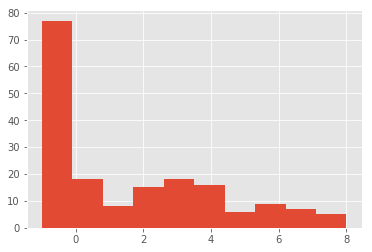

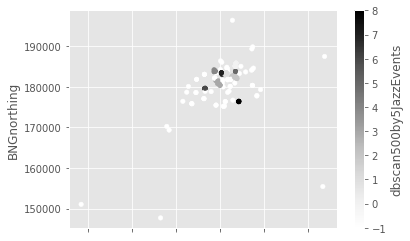

In [67]:
#now get folium map of clusters
#need to create the function to add labels of clusters to the dataframe
#eps 500 minsamples 5
# def SCANING_DB(eps_var = 0.1 , min_sample_var = 5, db = subset, lat_var = 'lat', lng_var = 'lng'):
#     dbscan = DBSCAN(eps=eps_var, min_samples = min_sample_var)
#     print(dbscan) 
#     arrey_coords = db[[lat_var, lng_var]].values
    #print(arrey_coords)
# try clustering out on the whole dataset
#     dbscan_result = dbscan.fit(arrey_coords)
#     dbscan_result_lbls = dbscan_result.labels_
#     return(dbscan_result_lbls)

dbscanJazzLabels = SCANING_DB(eps_var = 500, db = jazz, lat_var = 'BNGnorthing', lng_var = 'BNGeasting')

jazz['dbscan500by5JazzEvents'] = pd.DataFrame(dbscanJazzLabels)

jazz['dbscan500by5JazzEvents'].hist()

jazz.plot.scatter(y='BNGnorthing', x='BNGeasting', c='dbscan500by5JazzEvents')

In [68]:
epsDFevents.ClusterNosevents.unique()

array([117, 120, 115, 113, 111, 108, 107, 106, 105, 103, 101, 100,  97,
        96,  92,  90,  87,  83,  82,  78,  79,  77,  75,  70,  68,  67,
        65,  64,  66,  63,  61,  58,  56,  55,  54,  52,  51,  50,  49,
        47,  45,  43,  42,  41,  39,  38,  37,  35,  34,  33,  31,  32,
        30,  28,  27,  26,  24,  23,  22,  21,  19,  18,  17,  16,  15,
        14,  13,  11,  10,   9], dtype=int64)

In [69]:
#find the different labels inside the db
jazz.dbscan500by5JazzEvents.unique()

array([ 0, -1,  1,  2,  3,  4,  5,  6,  7,  8], dtype=int64)

In [273]:
dbscanJazzLabels = SCANING_DB(eps_var = 600, db = jazz, lat_var = 'BNGnorthing', lng_var = 'BNGeasting')

jazz['dbscan500by5jazzEvents'] = pd.DataFrame(dbscanJazzLabels)

In [274]:
dbscanFolkLabels = SCANING_DB(eps_var = 600, db = folk, lat_var = 'BNGnorthing', lng_var = 'BNGeasting')

folk['dbscan500by5folkEvents'] = pd.DataFrame(dbscanFolkLabels)

In [275]:
dbscanHouseLabels = SCANING_DB(eps_var = 600, db = house, lat_var = 'BNGnorthing', lng_var = 'BNGeasting')

house['dbscan500by5houseEvents'] = pd.DataFrame(dbscanHouseLabels)

In [276]:
dbscanClassicalLabels = SCANING_DB(eps_var = 600, db = classical, lat_var = 'BNGnorthing', lng_var = 'BNGeasting')

classical['dbscan500by5classicalEvents'] = pd.DataFrame(dbscanClassicalLabels)

In [277]:
dbscanReggaeLabels = SCANING_DB(eps_var = 600, db = reggae, lat_var = 'BNGnorthing', lng_var = 'BNGeasting')

reggae['dbscan500by5reggaeEvents'] = pd.DataFrame(dbscanReggaeLabels)

In [278]:
dbscanPunkLabels = SCANING_DB(eps_var = 600, db = punk, lat_var = 'BNGnorthing', lng_var = 'BNGeasting')

punk['dbscan500by5punkEvents'] = pd.DataFrame(dbscanPunkLabels)

In [279]:
dbscanTechnoLabels = SCANING_DB(eps_var = 600, db = techno, lat_var = 'BNGnorthing', lng_var = 'BNGeasting')

techno['dbscan500by5technoEvents'] = pd.DataFrame(dbscanTechnoLabels)

#possible colors
colors = [
    'red',
    'blue',
    'gray',
    'darkred',
    'lightred',
    'orange',
    'beige',
    'green',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'purple',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black']


# Polygon

In [226]:
import geopandas

lnd = geopandas.GeoDataFrame.from_file("D:/Documentos/GitHub/cityBlender/data-analysis/03_GIS/final_moran.shp")

In [247]:
def sub_genere_clus(genre='House', key_word = 'House'):
    sub = lnd[lnd[genre]==key_word]
    gjson = sub.to_crs(epsg='4326').to_json()
    
    mapa = folium.Map(location = [51.5, -0.1],
                 tiles= 'cartodbdark_matter',
                 zoom_start=10)

    polys = folium.features.GeoJson(gjson, 
                                    style_function=lambda feature: {
                                        'weight' : 1,
                                        'fillOpacity' : 0.2,
                                        'color': 'white'
                                    },
                                    
                                   )

    return(polys)
    

In [254]:
a = sub_genere_clus(genre='House', key_word = 'House')

In [264]:
type(a.data)

dict

In [271]:
a.data['features'][0]['properties']

{'BOROUGH': 'Southwark',
 'Classical': None,
 'Count_': 9,
 'Count_1': 1,
 'Count_10': 5,
 'Count_2': 1,
 'Count_3': 0,
 'Count_4': 2,
 'Count_5': 2,
 'Count_6': 0,
 'Count_7': 0,
 'Count_8': 1,
 'Count_9': 2,
 'Folk': None,
 'GSS_CODE': 'E05000540',
 'HECTARES': 114.662,
 'House': 'House',
 'Indie': None,
 'Jazz': None,
 'LB_GSS_CD': 'E09000028',
 'NAME': 'East Walworth',
 'POLY_ID': 117348,
 'Punk': None,
 'Reggae': None,
 'Rock': None,
 'Soul': None,
 'Techno': 'Techno'}

In [270]:
a.data['features'][0]['properties']['NAME']

'East Walworth'

In [272]:
a.data['features'][0]['properties']['BOROUGH']

'Southwark'

In [ ]:
a.data[]

#possible colors colors = [ 'red', 'blue', 'gray', 'darkred', 'lightred', 'orange', 'beige', 'green', 'darkgreen', 'lightgreen', 'darkblue', 'lightblue', 'purple', 'darkpurple', 'pink', 'cadetblue', 'lightgray', 'black']


In [280]:
def folium_map_genreclusters(db = jazz, clusterLabelColName = 'dbscan500by5JazzEvents',
                            genre='Jazz', key_word = 'Jazz'):
    latList = db['lat'].tolist()
    lngList = db['lng'].tolist()
    clusterLabelList = db[clusterLabelColName].tolist()
    medLat = db['lat'].median()
    medLng = db['lng'].median()
    
    this_map = folium.Map([medLat, medLng], zoom_start=12, tiles="cartodbdark_matter", control_scale=True)
    
    polys = sub_genere_clus(genre=genre, key_word = key_word)
    
    this_map.add_child(polys)   

    for lat, lng, label in zip(latList, lngList, clusterLabelList):
            if label == -1:
                this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 3, color='gray', fill_color='gray', fill_opacity=0.7))
            elif label == 0:
                this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 3, color='blue', fill_color='blue', fill_opacity=0.7))
            elif label == 1:
                this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 3, color='yellow', fill_color='yellow', fill_opacity=0.7))
            elif label == 2:
                this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 3, color='purple', fill_color='purple', fill_opacity=0.7))
            elif label == 3:
                this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 3, color='green', fill_color='green', fill_opacity=0.7))
            elif label == 4:
                this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 3, color='lightgreen', fill_color='lightgreen', fill_opacity=0.7))
            elif label == 5:
                this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 3, color='darkgreen', fill_color='darkgreen', fill_opacity=0.7))
            elif label == 6:
                this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 3, color='darkblue', fill_color='darkblue', fill_opacity=0.7))
            elif label == 7:
                this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 3, color='pink', fill_color='pink', fill_opacity=0.7))
            elif label == 8:
                this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 3, color='darkred', fill_color='darkred', fill_opacity=0.7))
            elif label == 9:
                this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 3, color='beige', fill_color='beige', fill_opacity=0.7))
            elif label == 10:
                this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 3, color='orange', fill_color='orange', fill_opacity=0.7))
            elif label == 11:
                this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 3, color='cadetblue', fill_color='cadetblue', fill_opacity=0.7))
            elif label == 12:
                this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 3, color='darkpurple', fill_color='darkpurple', fill_opacity=0.7))
            elif label == 13:
                this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 3, color='lightred', fill_color='lightred', fill_opacity=0.7))
            elif label == 14:
                this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 3, color='lightblue', fill_color='lightblue', fill_opacity=0.7))
            elif label == 15:
                this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 3, color='brown', fill_color='brown', fill_opacity=0.7))
            elif label == 16:
                this_map.add_child(folium.CircleMarker([lat, lng], 
#                                            popup=label, 
                                           radius = 3, color='darkblue', fill_color='darkblue', fill_opacity=0.7))
            else:
                pass
            
            
     
    return(this_map)

    

In [281]:
jazzClusterMap = folium_map_genreclusters(db = jazz, clusterLabelColName = 'dbscan500by5JazzEvents',
                            genre='Jazz', key_word = 'Jazz')

In [234]:
folkClusterMap = folium_map_genreclusters(db = folk, clusterLabelColName = 'dbscan500by5folkEvents',
                            genre='Folk', key_word = 'Folk')

In [235]:
houseClusterMap = folium_map_genreclusters(db = house, clusterLabelColName = 'dbscan500by5houseEvents',
                            genre='House', key_word = 'House')

In [236]:
classicalClusterMap = folium_map_genreclusters(db = classical, clusterLabelColName = 'dbscan500by5classicalEvents',
                            genre='Classical', key_word = 'Classical')

In [237]:
reggaeClusterMap = folium_map_genreclusters(db = reggae, clusterLabelColName = 'dbscan500by5reggaeEvents',
                            genre='Reggae', key_word = 'Reggae')

In [238]:
punkClusterMap = folium_map_genreclusters(db = punk, clusterLabelColName = 'dbscan500by5punkEvents',
                            genre='Punk', key_word = 'Punk')

In [239]:
technoClusterMap = folium_map_genreclusters(db = techno, clusterLabelColName = 'dbscan500by5technoEvents',
                            genre='Techno', key_word = 'Techno')

In [85]:
jazzClusterMap.save('C:/Users/Alfie/Documents/MSc Smart Cities/Term 2/Spatial Data Capture Storage and Analysis/Coursework/Maps/jazzClusterMap.html')

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Alfie/Documents/MSc Smart Cities/Term 2/Spatial Data Capture Storage and Analysis/Coursework/Maps/jazzClusterMap.html'

In [282]:
jazzClusterMap

In [ ]:
folkClusterMap.save('C:/Users/Alfie/Documents/MSc Smart Cities/Term 2/Spatial Data Capture Storage and Analysis/Coursework/Maps/folkClusterMap.html')

In [241]:
folkClusterMap

In [242]:
classicalClusterMap.save('C:/Users/Alfie/Documents/MSc Smart Cities/Term 2/Spatial Data Capture Storage and Analysis/Coursework/Maps/classicalClusterMap.html')

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Alfie/Documents/MSc Smart Cities/Term 2/Spatial Data Capture Storage and Analysis/Coursework/Maps/classicalClusterMap.html'

In [283]:
classicalClusterMap

In [ ]:
punkClusterMap.save('C:/Users/Alfie/Documents/MSc Smart Cities/Term 2/Spatial Data Capture Storage and Analysis/Coursework/Maps/punkClusterMap.html')

In [244]:
punkClusterMap

In [ ]:
technoClusterMap.save('C:/Users/Alfie/Documents/MSc Smart Cities/Term 2/Spatial Data Capture Storage and Analysis/Coursework/Maps/technoClusterMap.html')

In [ ]:
technoClusterMap

In [ ]:
reggaeClusterMap.save('C:/Users/Alfie/Documents/MSc Smart Cities/Term 2/Spatial Data Capture Storage and Analysis/Coursework/Maps/reggaeClusterMap.html')

In [245]:
reggaeClusterMap

In [ ]:
houseClusterMap.save('C:/Users/Alfie/Documents/MSc Smart Cities/Term 2/Spatial Data Capture Storage and Analysis/Coursework/Maps/houseClusterMap.html')

In [246]:
houseClusterMap